# Essay Scoring

Some enterprising individuals produced a whole bunch of ["AI-generated" essays using SOTA LLMs based on prompts from the PERSUADE dataset](https://www.kaggle.com/datasets/thedrcat/daigt-v2-train-dataset/data). These are for a competition to detect AI-generated text, and it has been observed that it is most likely that a subset of 7 PERSUADE prompts from which the data are drawn (the `RDizzl3_seven` set).

Note that nothing from the PERSUADE corpus itself is AI generated. All of the other essays are AI generated alternatives.

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from pathlib import Path
from os import getenv
from tqdm import tqdm

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score
from scipy.stats import ks_2samp

In [2]:
data_dir = Path(getenv("HOME"), "data", "llm-data", "ai-generated-essays")
daigt_fp = Path(data_dir, "train_v2_drcat_02.csv")
assert daigt_fp.exists()
essays = pd.read_csv(daigt_fp)

In [3]:
essays7 = essays.query("RDizzl3_seven").copy()

Scores are generated via [this Kaggle script](https://www.kaggle.com/code/carrot1500/daigt-llm-scoring) cause they nicely let me use GPUs.

In [4]:
gpt2_token_scores = {
    int(k): v for k, v in np.load(Path(data_dir, "llm-scores/gpt2-scores.npz")).items()
}

In [5]:
len(gpt2_token_scores)

20450

In [6]:
set(essays7.index.values) - set(gpt2_token_scores.keys())

set()

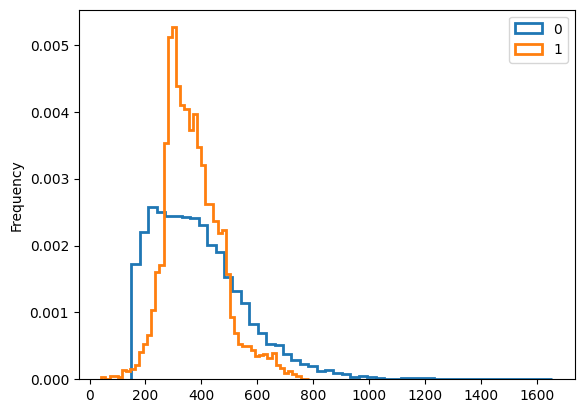

In [63]:
essays7["words"] = essays7.text.str.split().str.len()
essays7.groupby("label").words.plot.hist(
    bins=50, histtype="step", density=True, lw=2
)
plt.legend(loc="upper right")
plt.show()

In [32]:
color_scheme = dict()
cm = plt.get_cmap('gist_rainbow')
for i, k in enumerate(sorted(essays7.source.unique())):
    if k in {"train_essays", "persuade_corpus"}:
        color_scheme[k] = "black"
        continue
    color_scheme[k] = cm(1. * i / essays7.source.nunique())

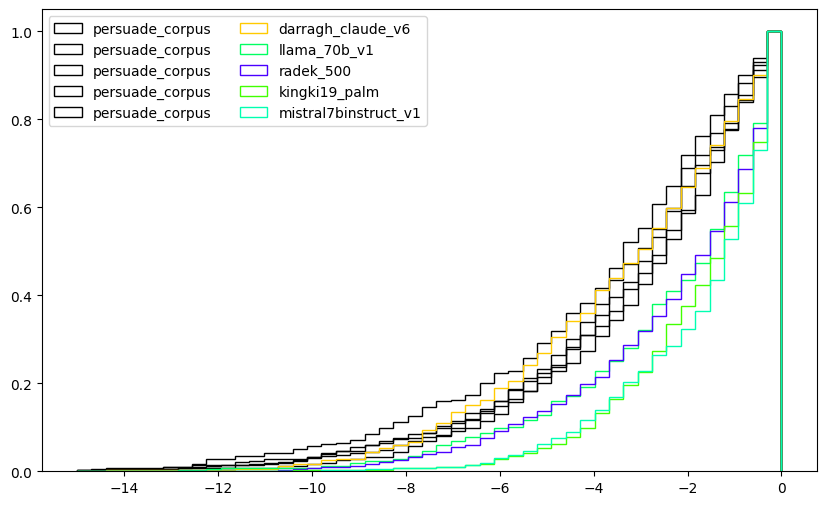

In [37]:
_fig, axes = plt.subplots(1, 1, figsize=(10, 6))
min_logp = -15
for _idx, _row in essays7.groupby("label").sample(5).iterrows():
    clip_logp = np.clip(gpt2_token_scores[_idx], min_logp, 0)
    axes.hist(
        clip_logp, 
        bins=np.linspace(min_logp, 0, 50),
        histtype="step",
        lw=1,
        color=color_scheme[_row.source],
        cumulative=True,
        density=True,
        label=_row.source
    )
plt.legend(loc="upper left", ncol=2)
plt.show()

# Method I: Scores

In [47]:
train = essays7.groupby("label").sample(frac=0.5)
test = essays7[~essays7.index.isin(train.index)]

In [43]:
def process_data(essays, lm_scores, min_score, nbins=20):
    bins = np.linspace(min_score, 0, nbins+1)
    vectors = np.zeros((essays.shape[0], nbins))
    for i, (_idx, _row) in enumerate(essays.iterrows()):
        vectors[i] = np.histogram(
            lm_scores[_idx], bins=bins
        )[0] / lm_scores[_idx].shape[0]
    return vectors, essays.label.values

In [49]:
x, y = process_data(train, gpt2_token_scores, -10)

In [55]:
mlp = MLPClassifier(
    early_stopping=True,
    validation_fraction=0.2
).fit(x, y)

In [56]:
xte, yte = process_data(test, gpt2_token_scores, -10)

In [61]:
roc_auc_score(y, mlp.predict_proba(x)[:, 1])

0.9374792982456142

In [62]:
roc_auc_score(yte, mlp.predict_proba(xte)[:, 1])

0.9406004753820033

# Method II: KS test statistics

In [81]:
def process_data(essays, llm_scores):
    ref_distributions = dict()

    for _corpus, _essays in essays.query("label == 1").groupby("source"):
        if "claude" not in _corpus:
            continue
        ref_distributions[_corpus] = np.concatenate([
            llm_scores[_idx] for _idx in _essays.index.values
        ])

    n_dists = len(ref_distributions)
    ks = sorted(ref_distributions.keys())
    vectors = np.zeros((essays.shape[0], 2 * n_dists))
    for i, _idx in tqdm(enumerate(essays.index.values), total=essays.shape[0]):
        for j, k in enumerate(ks):
            ksres = ks_2samp(ref_distributions[k], llm_scores[_idx])

In [82]:
process_data(essays7, gpt2_token_scores)

  2%|██▋                                                                                                       | 507/20450 [00:22<14:44, 22.54it/s]


KeyboardInterrupt: 